## 2. Analysis with GeoPandas
ENV 859 - Fall 2022  
© John Fay, Duke University

In this notebook, we examine how GeoPandas is used in peforming a spatial analysis. We take an example of looking at the demographic characteristics of where electric vehicle (EV) charging stations have been located in Durham, Wake, and Orange counties with respect to 2010 Census and Social Vulnerability Index values. (It's not a very sensible analysis as done here, but we are concentrating on the mechanics more than the utility of the analysis...)

### Learning Objectives:
* Executing a "***data science workflow***" with a GeoPandas
 - Read data into a geodataframe (CSV and GeoJSON)
 - Explore the data: columns/column types, summaries, plots
 - Analyze the data...
 - Visualize results
* **Subseting features** in a geodataframe by attribute
* **Merging** geodataframes
* **Dissolving** geodataframe features based on an attribute value
* **Joining attributes** to a geodataframe
* **Spatially joining** data from one geodataframe to another
* Generating various **plots** from single and multiple geodataframes
* **Saving** a geodataframe to a feature class 

### Workflow:
* [**Part 1: Fetching and Exploring Data**](#Part-1:-Fetching-and-Exploring-the-Data)
 * 1.1 Import packages
 * 1.2 Read CSV data into geodataframe
 * 1.3 Explore the data in the geodataframe
 * 1.4 Import census data to geodataframe via web service
* [**Part 2: Analysis (and Visualization)**](#Part-2:-The-Analysis-(and-Visualization))
 * 2.1 Subset EV features by attribute
 * 2.2 Merge the three county geodataframes into a single geodataframe
 * 2.3 Dissolve block features to the tract level
 * 2.4 Import and join the social vulnerability data to tract features
 * 2.5 Compute population density for each tract
 * 2.6 Subset EV stations spatially
 * 2.7 Spatially join tract attributes to EV features
* [**Part 3: Share Results**](#Part-3.-Share-results)
 * 3.1 Share your notebook as html or on GitHub
 * 3.2 Explot your geodataframe(s) as feature classes or CSV files

---

## Part 1: Fetching and Exploring the Data
Here we'll gather and explore the data we'll be using in our analysis. This includes two datasets. First is the list of EV Charging locations, stored as a CSV file in our data folder. This dataset has coordinate columns that we'll use to construct points and convert into a geodataframe as we learned in our previous lessons. 

The second dataset is comprised of 2010 Census BlockGroup data for all of North Carolina. We'll fetch these data from an on line resource using a web service. We'll revisit how web services later; for now, we'll use this process to fetch data for three counties: Durham, Wake, and Orange. 

For each dataset, we'll get the data into geodataframe format and then explore the data in various ways. Then we'll move to Part 2 where we analyse the data. 

### 1.1: Import packages needed in the analysis

In [1]:
#Import packages
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
#Command to run if autocomplete is slooooowwww
%config Completer.use_jedi = False

<H4 style="color:red">♦ Knowledge Check ♦</H4>  

_→ Can you explain what role each package imported might do in our analysis?_

### 1.2: Create a geodataframe from a CSV file
As done in a previous notebook, we want to:
* Import a CSV file containing coordinate columns into a Pandas dataframe,
* Create a collection of Shapely points from the coordinate fields, and 
* Create a geodataframe from the components. 

In [5]:
#Read in charging stations CSV, convert to geodataframe
df = pd.read_csv('../data/NC_Charging_Stations.csv')

#Create the geoseries from the X and Y columns
geom = gpd.points_from_xy(
    x=df['Longitude'],
    y=df['Latitude']
)

#Convert to a geodataframe, setting the CRS to WGS 84 (wkid=4326)
gdf_stations_all = gpd.GeoDataFrame(df,geometry=geom,crs=4326)

### 1.3: Explore the data in geodataframe
Have a quick look at the contents imported. Things to check include:
* How many rows and columns were imported
* The names, data types, and number of non-null values in each column
* Examine a single record from the geodataframe
* What geometry types are included in the geodataframe?
* Summary statistics of numeric columns, if applicable
* Correlations among column values, if applicable
* Spatial plot of the data

In [6]:
#Show the number rows and columns
gdf_stations_all.shape

(1227, 11)

In [11]:
#Examine the structure of the dataframe
gdf_stations_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1227 entries, 0 to 1226
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID              1227 non-null   int64   
 1   Fuel Type Code  1227 non-null   object  
 2   Station Name    1227 non-null   object  
 3   City            1227 non-null   object  
 4   State           1227 non-null   object  
 5   ZIP             1227 non-null   object  
 6   Status Code     1227 non-null   object  
 7   Latitude        1227 non-null   float64 
 8   Longitude       1227 non-null   float64 
 9   Facility Type   450 non-null    object  
 10  geometry        1227 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(7)
memory usage: 105.6+ KB


In [12]:
#Examine a single record of data
gdf_stations_all.iloc[0]

ID                                               39016
Fuel Type Code                                    ELEC
Station Name      City of Raleigh - Municipal Building
City                                           Raleigh
State                                               NC
ZIP                                              27601
Status Code                                          E
Latitude                                     35.778416
Longitude                                    -78.64347
Facility Type                           STREET_PARKING
geometry                   POINT (-78.64347 35.778416)
Name: 0, dtype: object

In [14]:
#Reveal the geometry type(s) contained inthe geodataframae
gdf_stations_all['geometry'].type.unique()

array(['Point'], dtype=object)

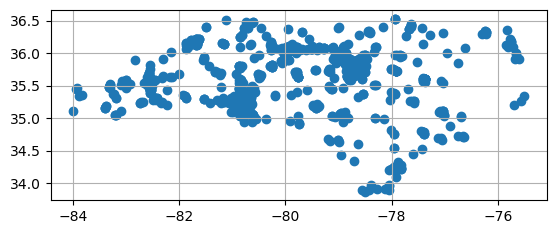

In [15]:
#Plot the data
gdf_stations_all.plot().grid()

<H3 style="color:red">♦ Knowledge Check ♦</H3>

→ _Could you performm the same steps of importing and exploring the USGS gage locations in NC stored in the CSV file `../data/gages.csv`?_
 * Convert data to a geodataframe: `gdf_gages`
 * Explore the data
 * Plot the gage sites

---
### 1.4. Import NC Census Block Group features via NC OneMap's web service
_We will explore web services a bit later, but we'll use the code below to acquire polygon data of census block groups for Durham, Wake, and Orange counties from an NC OneMap Web Service. Once imported, we'll merge these geodataframes together and use them in our subsequet analyses._

* First, to simplify matters, I've created a Python function to fetch data for a specific county given its FIPS code.  
(*We'll examine how this works a bit later...*)

In [16]:
#Create a function to read NCOneMap feature services into a geodataframe
def getBlockGroupData(FIPS):
    #Construct the url from the function arguments
    url=f'https://services.nconemap.gov/secure/rest/services/NC1Map_Census/FeatureServer/8/query?' + \
        f"where=GEOID10+LIKE+'{FIPS}%'&outFields=GEOID10,TOTAL_POP&f=geojson"
    
    #Create a geodataframe from the URL
    gdf = gpd.read_file(url)
    
    #Return the geodataframe
    return gdf

* Now, we apply that function for the three counties we want to examine

In [17]:
#Fetch census block groups for Durham, Orange, and Wake counties using the above function
gdf_DurmBlkGroups = getBlockGroupData(37063)
gdf_WakeBlkGroups = getBlockGroupData(37183)
gdf_OrangeBlkGroups = getBlockGroupData(37135)

* _Challenge: See if you can fetch Chatham county block groups (FIPS = 37037)_

In [18]:
#Challenge: See if you can fetch Chatham county block groups (FIPS = 37037)
gdf_Chatam = getBlockGroupData(37037)

* **Explore** the data...
 * What is its coordinate reference system?
 * What columns are included?
 * What does the first record look like?

In [22]:
#Show the Durham block group geodataframe's coordinate reference system
gdf_DurmBlkGroups.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
#Explore the Durham block group geodataframe's columns...
gdf_DurmBlkGroups.columns

Index(['geoid10', 'total_pop', 'geometry'], dtype='object')

In [26]:
#Examine a sample record from the geodataframe
gdf_DurmBlkGroups.iloc[10]

geoid10                                           370630007002
total_pop                                                 1030
geometry     POLYGON ((-78.9175097042526 35.97670311102937,...
Name: 10, dtype: object

* **Visualize** the data...

<AxesSubplot: >

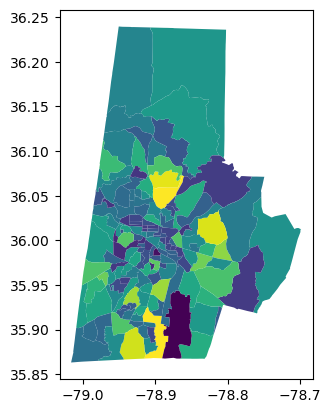

In [31]:
#Plot Durham's population, setting the colormap to "viridis"
gdf_DurmBlkGroups.plot(column='total_pop', cmap='viridis')

<AxesSubplot: >

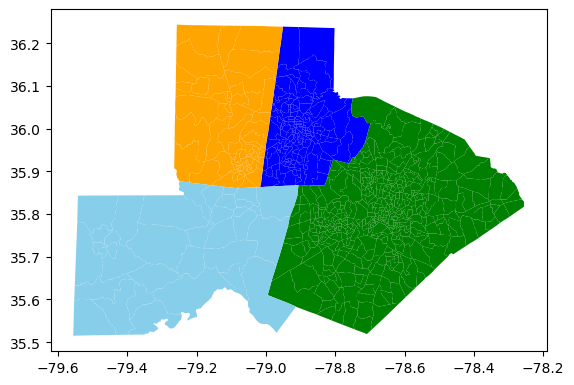

In [40]:
#Plot the block groups for all three counties
thePlot = gdf_DurmBlkGroups.plot(color='blue')
#First, plot one geodataframe, saving the output as "thePlot"

thePlot2 = gdf_WakeBlkGroups.plot(ax=thePlot, color='green')

#Plot another geodataframe, telling it to use the axes in "thePlot" created above

thePlot3 = gdf_OrangeBlkGroups.plot(ax=thePlot and thePlot2, color='orange')

#Repeat...
gdf_Chatam.plot(ax = thePlot and thePlot2 and thePlot3, color = 'skyblue')

---

## Part 2: The Analysis (and Visualization)
Now that we've obtained a few datasets and got them into geodataframes, we'll perform some analysis. These include:
* Subsetting the EV charging stations for those in specific cities.
* Identifying the census blocks surrounding each EV station, within a distance of 1km
 * To do this, we'll merge the Durham, Wake, and Orange Co block data selected above
 * Then we'll buffer our selected EV station points a distance of 1km
 * And finally, we'll select blocks that intersect the EV station buffers

### 2.1: Subset the EV Station points based on attribute values
Doc: https://geopandas.org/indexing.html

Subsetting features in a geodataframe uses the same methods as subsetting recordsin a Pandas dataframe. Here we'll run through an example by subsetting EV stations found oly within Durham, Raleigh, and Chapel Hill. 

* **2.1.1** Examine unique values in the `City` column

In [46]:
gdf_stations_all.head()

,ID,Fuel Type Code,Station Name,City,State,ZIP,Status Code,Latitude,Longitude,Facility Type,geometry
0,39016,ELEC,City of Raleigh - Municipal Building,Raleigh,NC,27601,E,35.778416,-78.643470,STREET_PARKING,POINT (-78.64347 35.77842)
1,39017,ELEC,City of Raleigh - Downtown,Raleigh,NC,27601,E,35.774350,-78.642287,STREET_PARKING,POINT (-78.64229 35.77435)
2,40066,ELEC,Modern Nissan - Concord,Concord,NC,28027,E,35.392063,-80.622777,CAR_DEALER,POINT (-80.62278 35.39206)
3,40067,ELEC,Fred Anderson Nissan,Fayetteville,NC,28304,E,35.042419,-78.956747,CAR_DEALER,POINT (-78.95675 35.04242)
4,40068,ELEC,Vann Yorks High Point Nissan,High Point,NC,27260,E,35.937981,-79.996012,CAR_DEALER,POINT (-79.99601 35.93798)


In [44]:
#Reveal the unique values in the City column
gdf_stations_all['City'].unique()

array(['Raleigh', 'Concord', 'Fayetteville', 'High Point', 'Lumberton',
       'Durham', 'Charlotte', 'Sanford', 'Burlington', 'Asheville',
       'Forest City', 'Gastonia', 'Goldsboro', 'Greensboro', 'Greenville',
       'Hendersonville', 'Hickory', 'Jacksonville', 'Montreat',
       'New Bern', 'Reidsville', 'Roanoke Rapids', 'Rockingham',
       'Mt. Airy', 'Salisbury', 'Southern Pines', 'Statesville',
       'Wake Forest', 'Wilkesboro', 'Wilmington', 'Wilson',
       'Winston-Salem', 'Clyde', 'Cornelius', 'Elizabeth City',
       'Asheboro', 'Black Mountain', 'Boone', 'Cary', 'Chapel Hill',
       'Hillsborough', 'Cherokee', 'Flat Rock', 'Clinton', 'Knightdale',
       'Mt. Holly', 'Mooresville', 'Weaverville', 'Fletcher', 'Pittsboro',
       'Belmont', 'Lowell', 'Dallas', 'Lincolnton', 'Arden',
       'Kernsersville', 'Mebane', 'Point Harbor', 'Nags Head',
       'Huntersville', 'Ocean Isle Beach', 'Holden Beach', 'Lenoir',
       'Waynesville', 'Maggie Valley', 'Granite Falls', '

* **2.2.2** Subset records for those where the City is "Durham", "Raleigh", or "Chapel Hill"

In [45]:
#Subset records where the City is "Durham", "Raleigh", or "Chapel Hill"
gdf_stations = gdf_stations_all.query('City in ("Raleigh", "Durham", "Chapel Hill")')
gdf_stations.shape

(205, 11)

In [47]:
#Recall, an alternative is to use masks...
gdf_stations = gdf_stations_all.loc[
    (gdf_stations_all['City'] == 'Raleigh')|
    (gdf_stations_all['City'] == 'Durham') |
    (gdf_stations_all['City'] == 'Chapel Hill')
]
gdf_stations.shape

(205, 11)

In [49]:
#Another, more efficient mask using `isin`
gdf_stations = gdf_stations_all.loc[gdf_stations_all['City'].isin(("Raleigh", "Durham", "Chapel Hill"))]
gdf_stations.shape

(205, 11)

* **2.1.3** Explore the results...

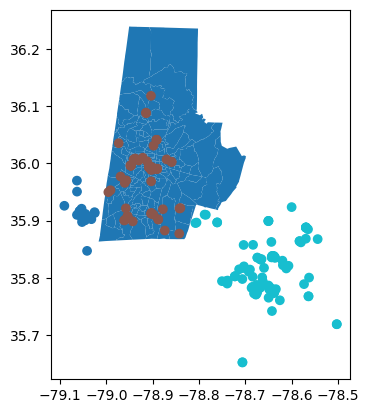

In [51]:
#Plot the results
myPlot = gdf_DurmBlkGroups.plot()
gdf_stations.plot("City", ax=myPlot);

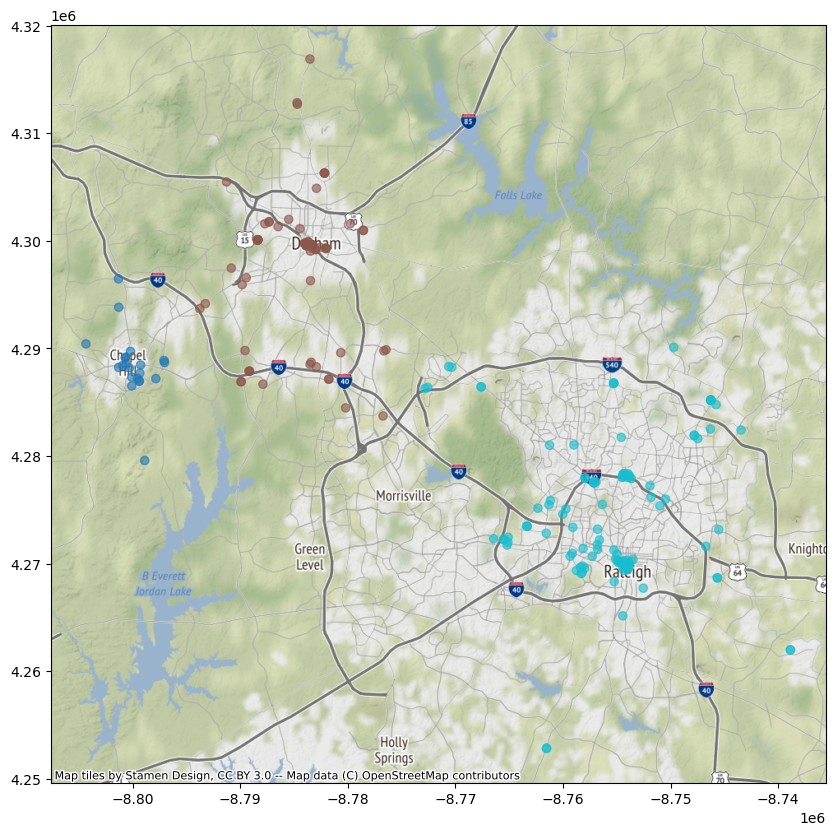

In [52]:
#Plot them with a base map (using Contextily - more later...)
city_plot = gdf_stations.to_crs(3857).plot(column="City",figsize=(10,10),alpha=0.6)
ctx.add_basemap(city_plot)

### 2.2: Merge the 3 county block group geodataframes into one
Doc: https://geopandas.org/mergingdata.html
1. Check that all data have the same crs
1. Optionally, add a field to identify the source geodataframe
1. Apply the `append()` function
1. Check/explore the result

We'll start by appending the Wake Co. dataset to the Durham Co. one. Then you will append the Orange Co. dataframe to that product.

* **2.2.1** Check that the two files share the same coordinate reference system  
 →*If the were different, we could use `to_crs()` to transform one dataset to use the crs of the other*

In [54]:
#Check the crs of the two geodataframes
gdf_DurmBlkGroups.crs == gdf_WakeBlkGroups.crs

True

* **2.2.2** Add an identifying column to the source geodataframes

In [55]:
#Add a field to each input, setting values to identify the source dataset
gdf_DurmBlkGroups['County'] = "Durham"
gdf_WakeBlkGroups['County'] = "Wake"
gdf_OrangeBlkGroups['County'] = "Orange"

* **2.2.3** Append one dataframe to the other

In [56]:
#Append the Wake Co features to the Durham Co features,
gdf_BlkGrp_step1 = gdf_DurmBlkGroups.append(gdf_WakeBlkGroups)

C:\Users\kbh40\AppData\Local\Temp\ipykernel_6100\4223542252.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf_BlkGrp_step1 = gdf_DurmBlkGroups.append(gdf_WakeBlkGroups)


* **2.2.4** Explore the result

In [58]:
#Check to see that the total rows in the merged gdf match the sum of the two component gdfs
gdf_DurmBlkGroups.shape[0] + gdf_WakeBlkGroups.shape[0] == gdf_BlkGrp_step1.shape[0]

True

<AxesSubplot: >

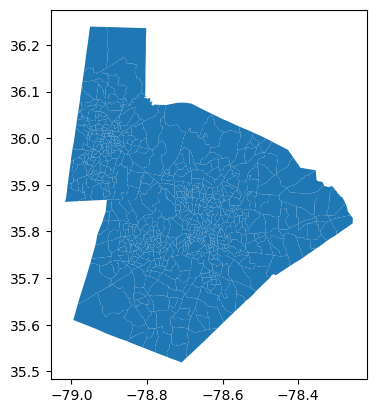

In [59]:
#Plot the result
gdf_BlkGrp_step1.plot()

---
<H4 style="color:red">♦ TASK ♦</H4>

_Append the Orange Co blockgroup features to the `gdf_BlkGrp_step` geodataframe we just created._  

**Remember to:**
* check that the coordinate refernce systems are the same, and 
* add a new column to the `gdf_OrangeBlkGroups`, setting its value to the County name.
 
→ Save the result as `gdf_BlkGrps`

In [60]:
#Check that the coordinate refernce systems are the same
gdf_DurmBlkGroups.crs == gdf_BlkGrp_step1.crs

True

In [ ]:
#Add the county field


In [ ]:
#Append the geodataframes


In [ ]:
#Plot the output


---
### 2.3: Dissolve block features to the tract level
We have Social Vulnerability Data to examine in our analysis, but these data are at the Tract, not BlockGroup level. Thus, to join these attributes to our geodataframe, we'll need to aggregate our blockgroups to the tract level. Fortunately, the `GEOID10` attribute is structured such that the census tract is just the first 11 characters. So we will create a new column holding these first 11 characters, and then we'll dissolve our blockgroup features sharing the same tract ID to single features.

Doc: https://geopandas.org/aggregation_with_dissolve.html
* First, create a new column listing tract IDs (the first 11 digits of the GEOID10)
* Dissolve the features on this attribute, computing aggregate sum of the TOTAL_POP field

* **2.3.1** Create the Tract column from the GEOID10 values

In [ ]:
#Create the Tract column
gdf_BlkGrp['TRACT']=
gdf_BlkGrp.head()

* **2.3.2** Disslve features on the Tract column

In [ ]:
#Dissolve features on tract, computing summed population
gdf_Tract =

#Show the results
gdf_Tract.head()

In [ ]:
#Plot the data


### 2.4: Import the Social Vulnerability Data and join with the Tract features
Now that we have the data at the tract level, we can join the Social Vulnerability Index data, stored in a CSV file (`./data/NC_SVI_2018.csv`).

Doc: https://geopandas.org/mergingdata.html#attribute-joins
* Import the SVI data as a Pandas dataframe
* Append records from the SVI dataframe to the Tracts geodataframe

* **2.4.1** Import and explore the SVI data into a Pandas dataframe

In [ ]:
#Import and explore the SVI data
df_SVI = 

>**Challenge**:<br>→ _Modify the `read_csv()` command above so that 'ST' and 'STCNTY' are also imported as strings._

In [ ]:
#Plot a histogram of the SVI values


<h3><font color='red'> Whoops!!! </h3>
Values should be between 0 and 1, but we see in the histogram that a few value are down near -1000. Turns out a few records have SVI values of -999. We need to remove those records.

In [ ]:
#Create a mask of values greater than or equal to zero

#Apply that mask


In [ ]:
#View the histogram again


_Phew! Exploring the data payed off!_

* **2.4.2** Append the dataframe to the tracts

In [ ]:
#Have a look at the merge command syntax
gdf_Tract.merge?

In [ ]:
#Join the SVI data to the tract features
gdf_Tract_joined = 

#Examine the output
gdf_Tract_joined.head()

In [ ]:
#Explore the output, look form null values


In [ ]:
#Plot the output


_Looks like we have some features missing SVI data. Let's examine those more closely._

In [ ]:
#Create a mask of null SVI values


In [ ]:
#Apply the mask


_We can either assign a value to these missing values or leave them as no data. We'll just leave them blank for now..._

### 2.5: Compute Population Density for Each Tract
Our combined dataframes have a field indicating the total population in each block group. We want to compute population density from this and from the area of each tract. We don't yet have an area field in our dataframe, but we can compute that from our spatial features. But before we can do this, we need to transform our data into a projected coordinate system. So... the steps for this analysis include:
* Transform the dataframe to a projected coordinate system (UTM Zone 17N)
* Compute a new `Area_km2` column in our dataframe
* Compute a new `PopDens` column in our dataframe by dividing `TOTAL_POP` by `Area_km` 

* **2.5.1** Transform the dataframe to a projected coordinate system (UTM Zone 17N)

In [ ]:
#Project the data to UTM Zone 17N (EPSG 32617)
gdf_Tract_utm = 

* **2.5.2** Compute a new `Area_km2` column in our dataframe

In [ ]:
#Compute a new column of geometry area (in sq km)
gdf_Tract_utm['Area_km2'] = 

* **2.5.3** Compute a new `PopDens` column in our dataframe by dividing `TOTAL_POP` by `Area_km` 

In [ ]:
#Compute a new column of population density
gdf_Tract_utm['PopDens'] = 

* **2.5.4** Explore the results

In [ ]:
#Plot the distribution of areas


In [ ]:
#Plot a map of log tranformed population density


* _**2.5.5** Log transform the data to improve the visualization_

In [ ]:
#Log transform the pop_dens data


In [ ]:
#Plot the log-transformed distribution of areas


In [ ]:
#Plot a map of log tranformed population density


### 2.6: Subset EV stations spatially
Doc: https://geopandas.org/set_operations.html  
Previously, we subset EV stations by an attribute (City). Here we'll see how we can instead select features spatially. We do this with GeoPanda's **Overlay** operations.

**To spatially select features**:
* Ensure both datasets share the same coordinate reference system; transform if needed
* Use the `overlay`:`intersection` operation to select EV features overlap with the Tracts dataset
* Examine the outputs

* **2.6.1** Ensure both datasets share the same crs; transform if not

In [ ]:
#Ensure both datasets share the same crs


In [ ]:
#Project one dataset to match the other


In [ ]:
#plot points on tracts


* **2.6.2** Select EV stations that intersect the county features

In [ ]:
#Intersect the two dataframes


* **2.6.3** Examine the results

In [ ]:
#View the data


In [ ]:
#Plot the data

#Construct the first (lowest layer) of the data to plot, saving it as "the_plot"
the_plot = gdf_Tract_utm.plot(
    color='lightgrey', #Set the fill of the Tract features
    edgecolor='grey',  #Set the edge color...
    alpha=0.4,         #Set the transparency...
    figsize=(12,12))   #Set the size of the figure

#Plot the stations, setting them to share the axes of "the_plot"
gdf_stations_select.plot(
    ax=the_plot,        #Draw it on the plot created above
    column='City',      #Color the features by values in the City column
    markersize=45,      #Set the size of the markers
    edgecolor='white'); #Set the edge color of the markers

#Use Contextily to add a nice backdrop
ctx.add_basemap(
    ax = the_plot,         #Add it to our existing plot 
    crs=gdf_Tract_utm.crs, #Transform the background to match the data's crs
    source=ctx.providers.CartoDB.Voyager) #Set the type of backdrop

### 2.7: Spatially join tract attributes to EV features
Doc: https://geopandas.org/mergingdata.html#spatial-joins

Now that we have a proper susbset of EV stations, let's add demographic data to our EV locations by peforming a spatial join with the tract geodataframe.

* **2.7.1** Ensure the datasets involved share the same coordinate reference system  
_→ What would happen if we made a typo and only included a single equals sign??_

In [ ]:
#Compare crs


* **2.7.2** Execute the spatial join

In [ ]:
#Execute the spatial join
gdf_JoinedData = 

* **2.7.3** Explore the result

In [ ]:
#View the data
gdf_JoinedData.info()

In [ ]:
#Plot
the_plot = gdf_Tract_utm.plot(
    color='lightgrey',
    edgecolor='grey',
    alpha=0.4,
    figsize=(12,12))

gdf_JoinedData.plot(
    ax=the_plot,
    column='SVI_ev',
    markersize=60,
    edgecolor='white');

ctx.add_basemap(
    ax=the_plot, 
    crs=gdf_Tract_utm.crs,
    source=ctx.providers.CartoDB.Voyager)

In [ ]:
#Make some graphical plots
ax=pd.DataFrame(gdf_JoinedData).boxplot(
    column='SVI_ev',
    by='City',
    rot=45,
    figsize=(19,5));

---

## Part 3. Share results
With this document we now have a fully reproducible analytic workflow, complete with visualizations of our result. We can export this notebook as an HTML document and share that, or if we commit this document to our GitHub account and share the link to that notebook. 

### 3.1: Sharing your notebook

* **3.1.1**
 * Export your completed notebook as an HTML document. 
 * View it in a web browser
 
* **3.1.2**
 * Commit the changes to your forked repository
 * Navigate to https://nbviewer.jupyter.org/ and paste your repository's URL
 * Share this link with others...

We can also save the resulting geodataframes as feature classes for more analysis, either in Python or in ArcGIS Pro. 

### 3.2: Exporting the geodataframe
We can export our `gdf_JoinedData` geodataframe easily,either as a shapefile or a CSV file. 

* **3.2.1** Export the final geodataframe to a feature class

In [ ]:
#Export the geodataframe to a shapefile
gdf_JoinedData.to_file(
    filename='../data/EV_sites_with_data.shp',
    driver='ESRI Shapefile',
    index=False
)

* **3.2.2** Export the final geodataframe to a csv file

In [ ]:
#Export the geodataframe to a CSV file
pd.DataFrame(gdf_JoinedData).to_csv(
    '../data/my_saved_data.csv',
    index=False
)